In [71]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import os

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
from sklearn import preprocessing

In [73]:
border_crossings_path = os.path.join('Datasets', 'border_crossings.csv')
border_crossings = pd.read_csv(border_crossings_path, low_memory=False)

cumulative_enrollment_path = os.path.join('Datasets', 'cumulative_enrollment.csv')
cumulative_enrollment = pd.read_csv(cumulative_enrollment_path, low_memory=False)

pubschools_info_path = os.path.join('Datasets', 'pubschools_info.csv')
pubschools_info = pd.read_csv(pubschools_info_path, low_memory=False)

stats_sd_path = os.path.join('Datasets', 'COVID_19_Statistics_San_Diego_County.csv')
stats_sd = pd.read_csv(stats_sd_path, low_memory=False)

#I'm having a bit of trouble loading this one in for some reason, I'll check it out later.
#age_stats_sd_path = os.path.join('Datasets', 'COVID-19_Age_Statistics_by_ZIP_Code')
#age_stats_sd = pd.read_csv(age_stats_sd_path, low_memory=False)

### Checklist:
    1. Get dtypes in order
        change dates to object datetime
        natural numbers to int
        decimals to float
    2. Remove columns that are not relevant
    3. Remove the unneeded symbols from string data
    4. Replace null/blank/missing values with NaN
    5. Look for and understand suspicious or out of place values for each column
    6. Fill missing values or drop them as needed (for this one we can discuss among us which is the best method to deal with 
       missingness for each dataset, as there are a lot of ways to do them.
                                        

# Cumulative Enrollment

In [74]:
#Removed insignificant columns
#Changed all * values (missing for student privacy) to NaN, rest of CumulativeEnrollment to float.
cumulative_clean = cumulative_enrollment.drop(["CountyCode", "DistrictCode", "SchoolCode", "ReportingCategory"], axis=1) #Dropped codes
cumulative_clean["CumulativeEnrollment"] = pd.to_numeric(cumulative_clean["CumulativeEnrollment"], errors='coerce')

In [75]:
cumulative_clean.head(5)

,AcademicYear,AggregateLevel,CountyName,DistrictName,SchoolName,Charter,CumulativeEnrollment
0,2018-19,S,Orange,Saddleback Valley Unified,Portola Hills Elementary,All,90.0
1,2018-19,S,Orange,Saddleback Valley Unified,Portola Hills Elementary,All,NaN
2,2018-19,S,Orange,Saddleback Valley Unified,Portola Hills Elementary,All,NaN
3,2018-19,S,Orange,Saddleback Valley Unified,Portola Hills Elementary,All,18.0
4,2018-19,S,Orange,Saddleback Valley Unified,Portola Hills Elementary,All,110.0


In [76]:
j = cumulative_clean[cumulative_clean['SchoolName'] == 'Central Elementary']
j[j['CountyName'] == 'San Diego'].head(3)
cumulat

,AcademicYear,AggregateLevel,CountyName,DistrictName,SchoolName,Charter,CumulativeEnrollment
6669,2018-19,S,San Diego,South Bay Union,Central Elementary,All,NaN
6670,2018-19,S,San Diego,South Bay Union,Central Elementary,All,35.0
6671,2018-19,S,San Diego,South Bay Union,Central Elementary,All,NaN


# COVID-19 Stats in San Diego 

In [77]:
stats_sd["date"] = pd.to_datetime(stats_sd["date"])

# Border Crossing

In [78]:
months = ["January", "February", "March", "April", "May", "June", "July"]
border = pd.read_csv("Datasets/border_crossings.csv")
#Dropped nans
border = border.dropna(axis=0)
for month in months:
    border[month] = border[month].str.replace(',', '').astype(int)
border.head(5)

,Port Name,Measure,January,February,March,April,May,June,July
0,Andrade,Pedestrians,113254,115655,75638,11190,23217,21886,19720
1,Andrade,Personal Vehicle Passengers,87090,82972,70204,29720,30962,29780,30439
2,Andrade,Personal Vehicles,46520,44277,39473,19102,18634,17926,18480
4,Brownsville,Bus Passengers,4467,3072,2572,405,776,1052,1200
5,Brownsville,Buses,508,469,419,134,178,201,206


# Public Schools

In [92]:
schools = pd.read_csv('Datasets/pubschools_info.csv')

schools = schools.loc[schools['County'] == 'San Diego']

cols_to_drop = ["NCESDist","NCESSchool","StreetAbr","MailStreet","MailStrAbr","MailCity",
               "MailZip","MailState","Ext","FaxNumber","Email","Phone","WebSite","CharterNum",
                "FundingType","DOC","DOCType","EdOpsCode","EdOpsName","Magnet","FederalDFCDistrictID",
                "AdmFName","AdmLName","AdmEmail","YearRoundYN",'Charter','State',
                  'OpenDate',"SOC", "SOCType", "EILName","GSoffered","GSserved",'ClosedDate']
#District 
schools = schools.drop(cols_to_drop, axis=1)

C:\Users\Andrew Chin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [93]:
clean1 = schools.loc[schools['StatusType'] == 'Active'] #Keeps only active schools
clean3 = clean1.loc[clean1['School'] != 'No Data'] #drops district records - nonschools
clean3['LastUpDate'] = pd.to_datetime(clean3['LastUpDate']) #change lastUpDate to datetime obj col
clean3 = clean3.reset_index().drop('index',axis = 1)
schools = clean3

schools = schools.replace("No Data",np.nan) #changed "No Data" into NaNs
schools['Latitude'] = schools['Latitude'].astype(float) #changed latitutde to float dtype
schools['Longitude'] = schools['Longitude'].astype(float) #changed longitude to float dtype
schools = schools.drop(['StatusType','County'],axis = 1) #dropped statustype and county col since its all active and SD county

# small_zip = schools['Zip'].str.slice(0,5).astype(float)
# schools = schools.assign(SmallZip=small_zip)

C:\Users\Andrew Chin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [94]:
address = schools['Street'] + ',' + schools['City'] + ",CA," + schools['Zip'].str.slice(0,5)
schools = schools.assign(Address = address).drop(["Street",'City'],axis = 1)
schools = schools.assign(Zipcode = schools['Zip'].str.slice(0,5))
schools['Zipcode'] = schools['Zipcode'].astype(int)

In [96]:
schools.head(1)

,CDSCode,District,School,Zip,EILCode,Virtual,Latitude,Longitude,LastUpDate,Address,Zipcode
0,37103710108548,San Diego County Office of Education,Iftin Charter,92115-3620,ELEM,N,32.757908,-117.07814,2020-08-13,"5465 El Cajon Boulevard,San Diego,CA,92115",92115


In [98]:
schools = schools.assign(DistrictSchool=schools['District'] + ',' + schools['School'])

In [100]:
schools.head(1)

,CDSCode,District,School,Zip,EILCode,Virtual,Latitude,Longitude,LastUpDate,Address,Zipcode,DistrictSchool
0,37103710108548,San Diego County Office of Education,Iftin Charter,92115-3620,ELEM,N,32.757908,-117.07814,2020-08-13,"5465 El Cajon Boulevard,San Diego,CA,92115",92115,"San Diego County Office of Education,Iftin Cha..."


### School Exploration

In [101]:
num_schools = len(schools)
unique_small_zips = schools['Zipcode'].nunique()
unique_zips = len(schools['Zip'].unique())
total_zips = len(schools['Zip'])

In [102]:
print("There are {} unique Zipcodes out of {}".format(unique_small_zips, total_zips))
print("There are {} unique Zips out of {}.".format(unique_zips,total_zips))

There are 101 unique Zipcodes out of 790
There are 703 unique Zips out of 790.


In [103]:
num_preschool = len(schools[schools['EILCode'] == 'PS'])
school_types = {}
for code in schools['EILCode'].unique():
    school_types[code] = (schools[schools['EILCode'] == code])
    
school_types['A'].head(5) #wier

,CDSCode,District,School,Zip,EILCode,Virtual,Latitude,Longitude,LastUpDate,Address,Zipcode,DistrictSchool
166,37681063730025,Escondido Union High,Escondido Adult,92025,A,C,33.131196,-117.08846,2020-07-16,"220 West Crest,Escondido,CA,92025",92025,"Escondido Union High,Escondido Adult"
191,37681303730199,Grossmont Union High,Foothills Adult Education Center,92019-2015,A,C,32.797130,-116.92436,2018-08-17,"1550 Melody Lane,El Cajon,CA,92019",92019,"Grossmont Union High,Foothills Adult Education..."
192,37681303730249,Grossmont Union High,El Cajon Adult Center,92021-6226,A,C,32.800160,-116.94594,2019-08-13,"1075 East Madison Avenue,El Cajon,CA,92021",92021,"Grossmont Union High,El Cajon Adult Center"
193,37681303730256,Grossmont Union High,Steele Canyon Adult Center,91978-2331,A,C,32.730297,-116.92517,2018-08-17,"12440 Campo Road,Spring Valley,CA,91978",91978,"Grossmont Union High,Steele Canyon Adult Center"
201,37681303732419,Grossmont Union High,Grossmont Adult,92019,A,C,32.797130,-116.92436,2020-08-25,"1550 Melody Lane,El Cajon,CA,92019",92019,"Grossmont Union High,Grossmont Adult"


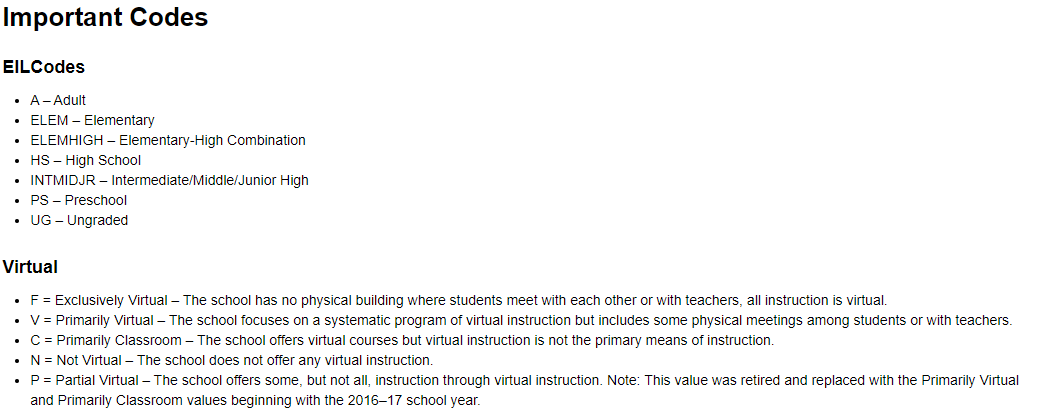

### Incomes

In [104]:
incomes_path = os.path.join('Datasets', 'suave_income.csv')
incomes = pd.read_csv(incomes_path, low_memory=False)

In [105]:
incomes_classes = incomes[["ZIP", 
         "Hholds with income Less than $10,000#number", 
         'Hholds with income $10,000 to $14,999#number',
         'Hholds with income $15,000 to $24,999#number',
         'Hholds with income $25,000 to $34,999#number',
         'Hholds with income $35,000 to $49,999#number',
         'Hholds with income $50,000 to $74,999#number',
         'Hholds with income $75,000 to $99,999#number',
         'Hholds with income $100,000 to $149,999#number',
         'Hholds with income $150,000 to $199,999#number',
         'Hholds with income $200,000 or more#number',
         'Median family income (dollars)#number',
         'Mean family income (dollars)#number',
         'Health insurance coverage, % of civilian pop#number',
         'No health insurance for civil pop#number',
         'No health insurance coverage, %#number',
         'Worked at home#number'
         ]]
incomes_clean = incomes_classes.copy()
incomes_clean["Households with income $0-34,999"] = (incomes_classes["Hholds with income Less than $10,000#number"] 
                                               + incomes_classes["Hholds with income $10,000 to $14,999#number"] 
                                               + incomes_classes["Hholds with income $15,000 to $24,999#number"] 
                                               + incomes_classes["Hholds with income $25,000 to $34,999#number"]
                                              )
incomes_clean["Households with income $35,000-99,999"] = (incomes_classes["Hholds with income $35,000 to $49,999#number"] 
                                               + incomes_classes["Hholds with income $50,000 to $74,999#number"] 
                                               + incomes_classes["Hholds with income $75,000 to $99,999#number"] 
                                              )
incomes_clean["Households with income $100,000+"] = (incomes_classes["Hholds with income $100,000 to $149,999#number"] 
                                               + incomes_classes["Hholds with income $150,000 to $199,999#number"]
                                               + incomes_classes["Hholds with income $200,000 or more#number"] 
                                              ) 
incomes_clean = incomes_clean.drop(["Hholds with income Less than $10,000#number", 
         'Hholds with income $10,000 to $14,999#number',
         'Hholds with income $15,000 to $24,999#number',
         'Hholds with income $25,000 to $34,999#number',
         'Hholds with income $35,000 to $49,999#number',
         'Hholds with income $50,000 to $74,999#number',
         'Hholds with income $75,000 to $99,999#number',
         'Hholds with income $100,000 to $149,999#number',
         'Hholds with income $150,000 to $199,999#number',
         'Hholds with income $200,000 or more#number',], axis=1)
incomes_clean = incomes_clean.rename(columns={'Median family income (dollars)#number': 'Median family income (dollars)',
                                             'Mean family income (dollars)#number' :'Mean family income (dollars)',
                                             'Health insurance coverage, % of civilian pop#number':'Health insurance coverage, % of civilian pop',
                                             'No health insurance for civil pop#number': 'No health insurance for civilian pop',
                                             'No health insurance coverage, %#number': 'No health insurance coverage %',
                                             'Worked at home#number': 'Worked at home',
                                             'ZIP': 'Zipcode'})
incomes_clean.head(5)

,Zipcode,Median family income (dollars),Mean family income (dollars),"Health insurance coverage, % of civilian pop",No health insurance for civilian pop,No health insurance coverage %,Worked at home,"Households with income $0-34,999","Households with income $35,000-99,999","Households with income $100,000+"
0,92536,76818.0,79336.0,90.3,292.0,9.7,43.0,353.0,425.0,283.0
1,91901,103026.0,116390.0,93.0,1265.0,7.0,788.0,1241.0,2264.0,2915.0
2,91902,104025.0,121292.0,88.6,2235.0,11.4,523.0,835.0,2416.0,2827.0
3,92003,76827.0,112047.0,94.3,293.0,5.7,336.0,343.0,850.0,612.0
4,92004,49451.0,56528.0,96.3,85.0,3.7,76.0,569.0,561.0,95.0


### Cleaned Demographics Data

In [106]:
cleaned_demo_path = os.path.join('Datasets', 'Cleaned_Demographics_Data.csv')
cleaned_demo = pd.read_csv(cleaned_demo_path, low_memory=False)
cleaned_demo.head(5)

,Unnamed: 0,date,age_9,age10_19,age20_29,age30_39,age40_49,age50_59,age60_69,age70_79,age80_plus,ageunknow,genderfemale,gendermale,newtests,newcases,test_positivity_rate
0,14,2020/03/25 08:00:00+00,3,3,66,89,61,53,26,25,14,1,134,207,1087,58,0.053
1,15,2020/03/26 08:00:00+00,3,4,84,106,73,65,31,29,20,2,166,249,1023,76,0.074
2,16,2020/03/27 08:00:00+00,3,5,102,118,85,74,36,38,25,2,206,280,776,71,0.091
3,17,2020/03/28 08:00:00+00,4,6,107,130,90,79,37,39,26,1,219,298,1275,31,0.024
4,18,2020/03/29 08:00:00+00,4,6,121,148,105,91,52,45,29,2,256,345,687,84,0.122


### Cleaned Cases by Zipcode

In [107]:
cleaned_cases_path = os.path.join('Datasets', 'Cleaned_Cases_by_Zipcode.csv')
cleaned_cases = pd.read_csv(cleaned_cases_path, low_memory=False)
cleaned_cases.head(5)

,Unnamed: 0,Zipcode,case_count,updatedate
0,0,91901,1,2020/04/01 08:00:00+00
1,1,91902,9,2020/04/01 08:00:00+00
2,2,91910,23,2020/04/01 08:00:00+00
3,3,91911,21,2020/04/01 08:00:00+00
4,4,91913,20,2020/04/01 08:00:00+00


# Data Exploration

In [108]:
final = pd.read_csv('Datasets/schools_data.csv')
final = final.drop(['Unnamed: 0'], axis = 1)

In [109]:
print(final.columns) #Columns

Index(['AggregateLevel', 'CountyName', 'DistrictName', 'School',
       'ReportingCategory', 'CumulativeEnrollment', 'CDSCode', 'Zip',
       'WebSite', 'EILName', 'Latitude', 'Longitude', 'LastUpDate', 'Address',
       'Zipcode', 'Median family income (dollars)',
       'Mean family income (dollars)',
       'Health insurance coverage, % of civilian pop',
       'No health insurance for civilian pop',
       'No health insurance coverage %', 'Worked at home',
       'Households with income $0-34,999',
       'Households with income $35,000-99,999',
       'Households with income $100,000+'],
      dtype='object')


In [110]:
print(final['CDSCode'].nunique(), " Unique CDCScodes")
print(len(final), " Number of rows in final")

619  Unique CDCScodes
647  Number of rows in final


In [111]:
final[final['CDSCode'] == 37683386039366] #Here we can see that there are multiple district names for the same school

,AggregateLevel,CountyName,DistrictName,School,ReportingCategory,CumulativeEnrollment,CDSCode,Zip,WebSite,EILName,...,Zipcode,Median family income (dollars),Mean family income (dollars),"Health insurance coverage, % of civilian pop",No health insurance for civilian pop,No health insurance coverage %,Worked at home,"Households with income $0-34,999","Households with income $35,000-99,999","Households with income $100,000+"
50,S,San Diego,South Bay Union,Central Elementary,TA,594.0,37683386039366,92105-1436,http://www.sandi.net/central,Elementary,...,92105,41703.0,54828.0,82.3,12901.0,17.7,1112.0,9562.0,9180.0,2797.0
54,S,San Diego,National Elementary,Central Elementary,TA,636.0,37683386039366,92105-1436,http://www.sandi.net/central,Elementary,...,92105,41703.0,54828.0,82.3,12901.0,17.7,1112.0,9562.0,9180.0,2797.0
58,S,San Diego,San Diego Unified,Central Elementary,TA,838.0,37683386039366,92105-1436,http://www.sandi.net/central,Elementary,...,92105,41703.0,54828.0,82.3,12901.0,17.7,1112.0,9562.0,9180.0,2797.0
62,S,San Diego,Escondido Union,Central Elementary,TA,649.0,37683386039366,92105-1436,http://www.sandi.net/central,Elementary,...,92105,41703.0,54828.0,82.3,12901.0,17.7,1112.0,9562.0,9180.0,2797.0


In [113]:
final[final['School'] == 'Central Elementary'].head(5)

,AggregateLevel,CountyName,DistrictName,School,ReportingCategory,CumulativeEnrollment,CDSCode,Zip,WebSite,EILName,...,Zipcode,Median family income (dollars),Mean family income (dollars),"Health insurance coverage, % of civilian pop",No health insurance for civilian pop,No health insurance coverage %,Worked at home,"Households with income $0-34,999","Households with income $35,000-99,999","Households with income $100,000+"
48,S,San Diego,South Bay Union,Central Elementary,TA,594.0,37680986038178,92025-4134,http://www.eusd.org,Elementary,...,92025,59509.0,85640.0,79.6,10756.0,20.4,1310.0,4812.0,6688.0,3681.0
49,S,San Diego,South Bay Union,Central Elementary,TA,594.0,37682216038731,91950-3416,NaN,Elementary,...,91950,46370.0,59556.0,82.2,10279.0,17.8,2553.0,6779.0,7363.0,2404.0
50,S,San Diego,South Bay Union,Central Elementary,TA,594.0,37683386039366,92105-1436,http://www.sandi.net/central,Elementary,...,92105,41703.0,54828.0,82.3,12901.0,17.7,1112.0,9562.0,9180.0,2797.0
51,S,San Diego,South Bay Union,Central Elementary,TA,594.0,37683956040471,91932-2920,NaN,Elementary,...,91932,53791.0,68606.0,85.3,3846.0,14.7,499.0,2778.0,4477.0,1592.0
52,S,San Diego,National Elementary,Central Elementary,TA,636.0,37680986038178,92025-4134,http://www.eusd.org,Elementary,...,92025,59509.0,85640.0,79.6,10756.0,20.4,1310.0,4812.0,6688.0,3681.0


In [114]:
zipcode_income = final.groupby('Zipcode')['Mean family income (dollars)'].mean()
rich_zip = zipcode_income.sort_values(ascending = False).idxmax()
#Grouped by zipcode aggr by mean family income. found mean of that

### Mean Fam Income vs Health Insur Coverage %

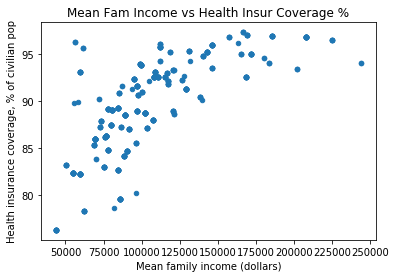

In [127]:
final.plot.scatter(x='Mean family income (dollars)', y = 'Health insurance coverage, % of civilian pop').title.set_text(
    "Mean Fam Income vs Health Insur Coverage %")

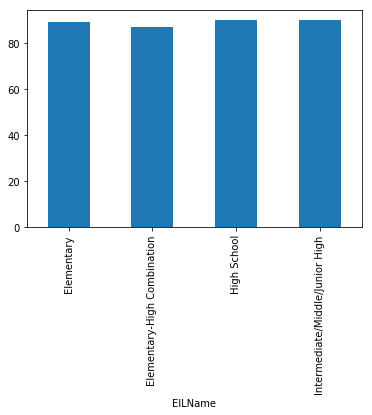

In [132]:
final.groupby('EILName')['Health insurance coverage, % of civilian pop'].mean().plot.bar(x='EILName', y = 'Health insurance coverage, % of civilian pop')